# Multi-Armed Bandit Algorithms on Networks

In [38]:
import os
import time
import random

import numpy as np
import pandas as pd

import igraph as ig
import binarytree as bt

import matplotlib.cm as cm
import matplotlib.pyplot as plt

from itertools import product
from collections import defaultdict
from scipy.spatial.distance import cdist

In [39]:
# EXP3 #

def EXP3(actions, rate):
    # Weights of Experts
    weights = np.full(actions, np.divide(1.0, actions))
    
    # Losses of Experts
    losses = np.zeros(actions)
    
    # Losses of Learner
    losses_EXP3 = np.zeros(trials)
    
    for t in range(trials):
        # Sample an Action Based on Weights
        choice = np.random.choice(actions, p = weights)
        
        # Initialize Random Losses for Different Experts
        losses = np.random.uniform(high = typical, size = actions)
        losses[0] = np.random.uniform(high = optimal)
        
        # Incur Loss of Learner
        losses_EXP3[t] = losses[choice]
        
        # Update Weights
        scaled = np.divide(losses[choice], weights[choice])
        weights[choice] *= np.exp(np.multiply(-rate, scaled))
        
        weights = np.divide(weights, np.sum(weights))
    
    print(f'Loss: {np.sum(losses_EXP3)}')
    return np.cumsum(losses_EXP3)

In [47]:
# MNIST #

KNN = 3
users = 64

cwd = os.getcwd()
path = os.path.join(cwd, 'Files', 'train.dat')

with open(path) as f:
    lines = f.readlines()

np.random.shuffle(lines)
elements = lines[ : users]

labels = []
matrix = []

for i in elements:
    values = i.split()
    
    labels.append(values[0])
    matrix.append(values[1 : ])

# print(labels)
# print(matrix)

In [48]:
df_matrix = pd.DataFrame(matrix)
df_matrix = df_matrix.apply(pd.to_numeric, errors = 'ignore')

# Euclidean Distance #

dist = cdist(df_matrix, df_matrix, 'euclid')
df_dist = pd.DataFrame(dist)

# K-Nearest Neighbors #

knn = np.argsort(df_dist.values, axis = 1)[ : , 1 : KNN + 1]
df_knn = pd.DataFrame(knn)

# Adjacency Matrix #

df_am = pd.DataFrame(np.zeros(df_dist.shape))

for i, row in df_knn.iterrows():
    df_am.loc[row.values, i] = 1.0
    df_am.loc[i, row.values] = 1.0

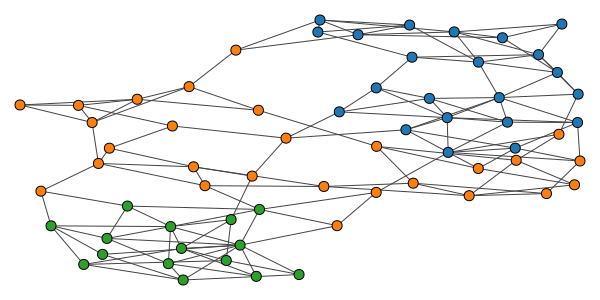

In [49]:
# KNN Graph #

graph = ig.Graph.Adjacency(df_am.values)
# graph.vs['label'] = labels
graph.to_undirected()

color_map = {}
palette = cm.tab10.colors

unique = set(labels)
classes = len(unique)

for index, label in enumerate(unique):
    color_map[label] = palette[index]

colors = [color_map[i] for i in labels]

visual_style = {}

visual_style['vertex_size'] = 10
visual_style['vertex_label_dist'] = 2
visual_style['vertex_label_size'] = 10
visual_style['vertex_color'] = colors
visual_style['bbox'] = (600, 300)

layout = graph.layout('auto')
ig.plot(graph, layout = layout, **visual_style)

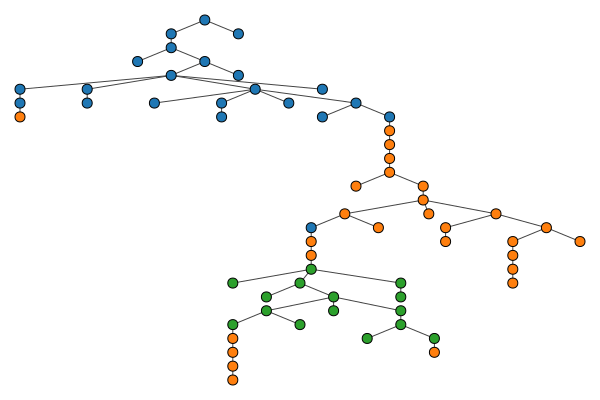

In [50]:
# Random Spanning Tree (RST) #

root = 0

def RST(graph, root = root):
    edges, visited = [], [root]
    
    node = root
    while (len(visited) < graph.vcount()):
        neighbors = graph.neighbors(node)
        choice = np.random.choice(neighbors)
        
        if choice not in visited:
            visited.append(choice)
            edges.append((node, choice))
        
        node = choice
    
    return edges

edges = RST(graph)

rst = ig.Graph(edges = edges)
# rst.vs['label'] = labels

visual_style = {}

visual_style['vertex_size'] = 10
visual_style['vertex_label_dist'] = 2
visual_style['vertex_label_size'] = 10
visual_style['vertex_color'] = colors
visual_style['bbox'] = (600, 400)

layout = rst.layout('tree', root = [root])
layout.mirror(0)

ig.plot(rst, layout = layout, **visual_style)

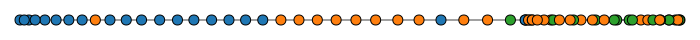

In [51]:
# Depth-First Search #

vertices, parents = rst.dfs(vid = root)
# print(vertices)

# Sequence of Nodes - Spine #

edges = zip(vertices, vertices[1 : ])

spine = ig.Graph(edges = edges)
# spine.vs['label'] = labels

visual_style = {}

visual_style['vertex_size'] = 10
visual_style['vertex_label_dist'] = 2
visual_style['vertex_label_size'] = 10
visual_style['vertex_color'] = colors
visual_style['bbox'] = (700, 40)

layout = spine.layout('drl')
ig.plot(spine, layout = layout, **visual_style)

In [52]:
# Initialize Best Actions #

def init_matching():
    spine = map(float, [labels[i] for i in vertices])
    return np.fromiter(spine, dtype = int) - 1

def init_stochastic():
    return np.random.randint(low = 0, high = classes, size = users)

def init_uniform(value = 0):
    return np.full(users, value, dtype = int)

In [53]:
# Forward-Backward #

beta = 0.1

# Helper Functions

def transition(a, b):
    if (a == b): return (1 - beta)
    return np.divide(beta, actions - 1)

def _F(pi, fi, u, a):
    _transitions = np.full(actions, transition(0, 1))
    _transitions[a] = transition(0, 0)
    
    return np.sum(np.multiply(fi[u - 1], _transitions))

def _B(pi, psi, u, a):
    _transitions = np.full(actions, transition(0, 1))
    _transitions[a] = transition(0, 0)
    
    x = np.multiply(pi[u + 1], psi[u + 1])
    
    return np.sum(np.multiply(x, _transitions))

# Main Function
def FB(pi, fi, psi):
    _users, _actions = range(users), range(actions)
    
    # Combinations of Users and Actions
    f_combinations = product(_users[1 : ], _actions)
    b_combinations = product(_users[-2 : : -1], _actions)
    
    # Forward Pass
    fi[0] = pi[0]
    
    for u, a in f_combinations:
        fi[u][a] = np.multiply(pi[u][a], _F(pi, fi, u, a))
    
    # Backward Pass
    psi[-1] = 1.0
    
    for u, a in b_combinations:
        psi[u][a] = _B(pi, psi, u, a)
    
    return fi, psi

In [54]:
# Multi-Task Hedge #

# Full Information
def MTH_F(method):
    # Losses of Experts
    losses = np.zeros(actions)
    
    # Losses of Learner
    losses_MTH = np.zeros(trials)
    
    # Best Actions of Users
    best_actions = method()
    
    shape = (users, actions)
    
    pi = np.ones(shape)
    fi = np.ones(shape)
    psi = np.ones(shape)
    
    for t in range(trials):
        # Environment Selects User
        index = np.random.randint(users)
        best = best_actions[index]
        
        # Initialize Random Losses for Different Experts
        losses = np.random.uniform(high = typical, size = actions)
        losses[best] = np.random.uniform(high = optimal)
        
        # Determine Fi and Psi
        fi, psi = FB(pi, fi, psi)
        
        # Determine Prediction
        prediction = np.multiply(fi[index], psi[index])
        prediction = np.divide(prediction, np.sum(prediction))
        
        # Incur Loss of Learner
        losses_MTH[t] = np.dot(prediction, losses)
        
        # Update Pi
        pi[index] *= np.exp(np.multiply(-rate, losses))
    
    print(f'Loss: {np.sum(losses_MTH)}')
    return np.cumsum(losses_MTH)

# Bandit Setting
def MTH_B(method):
    # Losses of Experts
    losses = np.zeros(actions)
    
    # Losses of Learner
    losses_MTH = np.zeros(trials)
    
    # Best Actions of Users
    best_actions = method()
    
    shape = (users, actions)
    
    pi = np.ones(shape)
    fi = np.ones(shape)
    psi = np.ones(shape)
    
    for t in range(trials):
        # Environment Selects User
        index = np.random.randint(users)
        best = best_actions[index]
        
        # Initialize Random Losses for Different Experts
        losses = np.random.uniform(high = typical, size = actions)
        losses[best] = np.random.uniform(high = optimal)
        
        # Determine Fi and Psi
        fi, psi = FB(pi, fi, psi)
        
        # Determine Prediction
        prediction = np.multiply(fi[index], psi[index])
        prediction = np.divide(prediction, np.sum(prediction))
        
        # Sample an Action Based on Prediction Vector
        choice = np.random.choice(actions, p = prediction)
        
        # Incur Loss of Learner
        losses_MTH[t] = losses[choice]
        
        # Update Pi
        scaled = np.divide(losses[choice], prediction[choice])
        pi[index][choice] *= np.exp(np.multiply(-rate, scaled))
    
    print(f'Loss: {np.sum(losses_MTH)}')
    return np.cumsum(losses_MTH)

In [55]:
# Binary Support Tree (BST) #
def ancestors(tree, value):
    ancestors = []
    
    for n in tree:
        if (value in n.values):
            ancestors.append(n)
    
    return ancestors

height = np.log2(users)
tree = bt.tree(height = int(height), is_perfect = True)

size, height = tree.size, tree.height
values, leaves = tree.values, tree.leaves

In [56]:
# GABA-I #

# Helper Functions

def init_alpha(shape, b):
    ones = np.ones(actions)
    alpha = np.zeros(shape)
    
    combinations = product(leaves, b, b)
    
    for n, i, j in combinations:
        if (i != j): alpha[n.value][i][j] = np.multiply(f, ones)
        if (i == j): alpha[n.value][i][j] = np.multiply(1 - f, ones)
    
    for d in range(1, height):
        combinations = product(tree.levels[height - d], b, b, b)
        
        for n, i, j, k in combinations:
            alpha_l = alpha[n.left.value][i][k]
            alpha_r = alpha[n.right.value][k][j]
            
            alpha[n.value][i][j] += np.multiply(alpha_l, alpha_r)
    
    return alpha

def update_alpha(alpha, anc, pi, b):
    ones = np.ones(actions)
    
    alpha[anc[height].value][1] *= pi
    combinations = product(anc[1 : height], b, b, b)

    for v, i, j, k in combinations:
        if (k == 0): alpha[v.value][i][j] = 0.0

        alpha_l = alpha[v.left.value][i][k]
        alpha_r = alpha[v.right.value][k][j]

        alpha[v.value][i][j] += np.multiply(alpha_l, alpha_r)
    
    return alpha

def init_beta(shape, alpha, anc, b):
    ones = np.ones(actions)
    
    beta_r, beta_l = np.zeros(shape), np.zeros(shape)
    
    beta_r[0][0], beta_r[0][1] = ones, ones
    
    beta_l[0][0] = np.multiply(np.divide(ones, actions), actions - 1)
    beta_l[0][1] = np.divide(ones, actions)
    
    for d in range(1, height + 1):
        if (anc[d] == anc[d - 1].left):
            for i, j in product(b, b):
                beta_p = beta_r[d - 1][j]
                alpha_r = alpha[anc[d - 1].right.value][i][j]
                
                beta_l[d][i] = beta_l[d - 1][i]
                beta_r[d][i] += np.multiply(alpha_r, beta_p)
        
        if (anc[d] == anc[d - 1].right):
            for i, j in product(b, b):
                beta_p = beta_l[d - 1][j]
                alpha_l = alpha[anc[d - 1].left.value][j][i]
                
                beta_r[d][i] = beta_r[d - 1][i]
                beta_l[d][i] += np.multiply(alpha_l, beta_p)
    
    return beta_l, beta_r

# Main Function
def GABA_I(method):
    # Losses of Experts
    losses = np.zeros(actions)
    
    # Losses of Learner
    losses_GABA_I = np.zeros(trials)
    
    # Best Actions of Users
    best_actions = method()
    
    b = [0, 1]
    
    # Initialize Alpha
    shape = (size, len(b), len(b), actions)
    alpha = init_alpha(shape, b)
    
    for t in range(trials):
        # Environment Selects User
        index = np.random.randint(users)
        best = best_actions[index]
        
        # Determine Ancestors
        anc = ancestors(tree, leaves[index].value)
        
        # Initialize Random Losses for Different Experts
        losses = np.random.uniform(high = typical, size = actions)
        losses[best] = np.random.uniform(high = optimal)
        
        # Initialize Beta
        shape = (len(anc), len(b), actions)
        beta_l, beta_r = init_beta(shape, alpha, anc, b)
        
        # Calculate Probability Vector
        m, n = beta_l[height][1], beta_r[height]
        o = alpha[anc[height].value][1]
        
        p = np.multiply(m, np.multiply(n, o)).sum(axis = 0)
        
        prediction = np.divide(p, actions)
        norm = np.sum(prediction)
        
        probability = np.divide(prediction, norm)
        
        # Sample an Action Based on Probability Vector
        choice = np.random.choice(actions, p = probability)
        
        # Incur Loss of Learner
        losses_GABA_I[t] = losses[choice]
        
        # Calculate C
        c = np.ones(actions)
        c[choice] = np.exp(-rate * losses[choice] / probability[choice])
        
        # Calculate Pi
        pi = np.divide(np.multiply(norm, c), np.dot(prediction, c))
        
        # Update Alpha
        alpha = update_alpha(alpha, anc, pi, b)
    
    print(f'Loss: {np.sum(losses_GABA_I)}')
    return np.cumsum(losses_GABA_I)

In [57]:
# Plot Function #

def plot(graphs, labels, title = ''):
    x = np.linspace(1, trials, num = trials)
    
    opt = np.multiply(x, np.divide(optimal, 2.0))
    typ = np.multiply(x, np.divide(typical, 2.0))
    
    fig, ax = plt.subplots(figsize = (14, 8))
    # fig, ax = plt.subplots(figsize = (10, 6))
    
    ax.plot(opt, label = 'Optimal')
    ax.plot(typ, label = 'Typical')
    
    for graph, label in zip(graphs, labels):
        ax.plot(graph, label = label)
    
    plt.xlabel('Trials', fontsize = 14)
    plt.ylabel('Cumulative Loss', fontsize = 14)
    
    plt.legend(loc = 'best')
    plt.title(title, fontsize = 14)
    
    plt.show()

In [58]:
# Experiments #

f = 0.1

beta = 0.1
rate = 0.2

optimal = 0.1
typical = 0.2

Loss: 672.9569701918359
Time: 0.3706674575805664


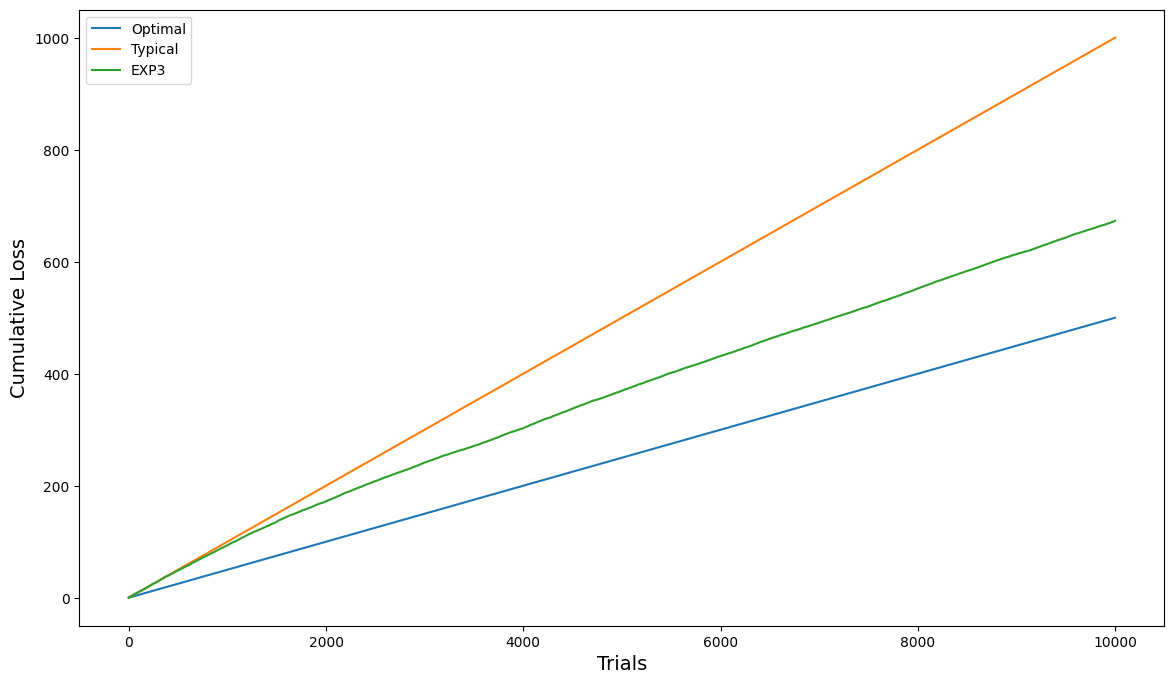

In [59]:
# EXP3 - Time
trials = 10000

start = time.time()
EXP3_G = EXP3(64, rate)
end = time.time()

print(f'Time: {end - start}')
plot([EXP3_G], ['EXP3'])

Loss: 546.2321622183405
Loss: 594.3224661179768
Loss: 770.8502996569088


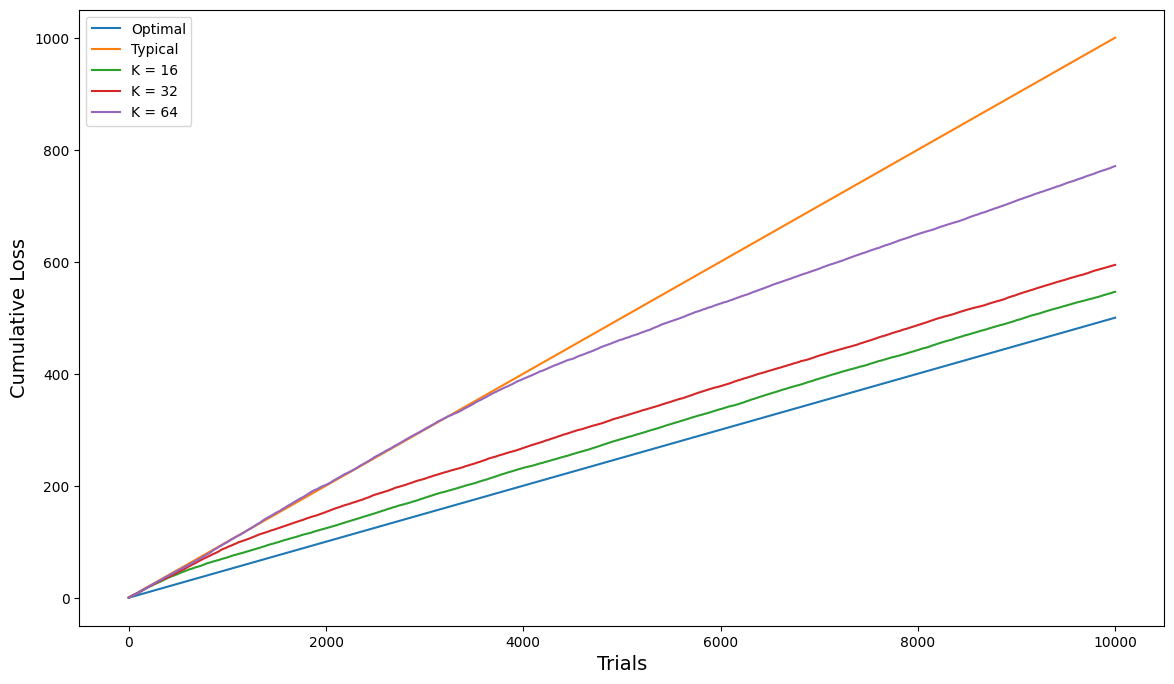

In [60]:
# EXP3 - Actions
trials = 10000

EXP3_16 = EXP3(16, rate)
EXP3_32 = EXP3(32, rate)
EXP3_64 = EXP3(64, rate)

plot([EXP3_16, EXP3_32, EXP3_64], ['K = 16', 'K = 32', 'K = 64'])

Loss: 546.8401261636639
Loss: 688.6448678976991
Loss: 797.793715307977
Time: 669.7496411800385


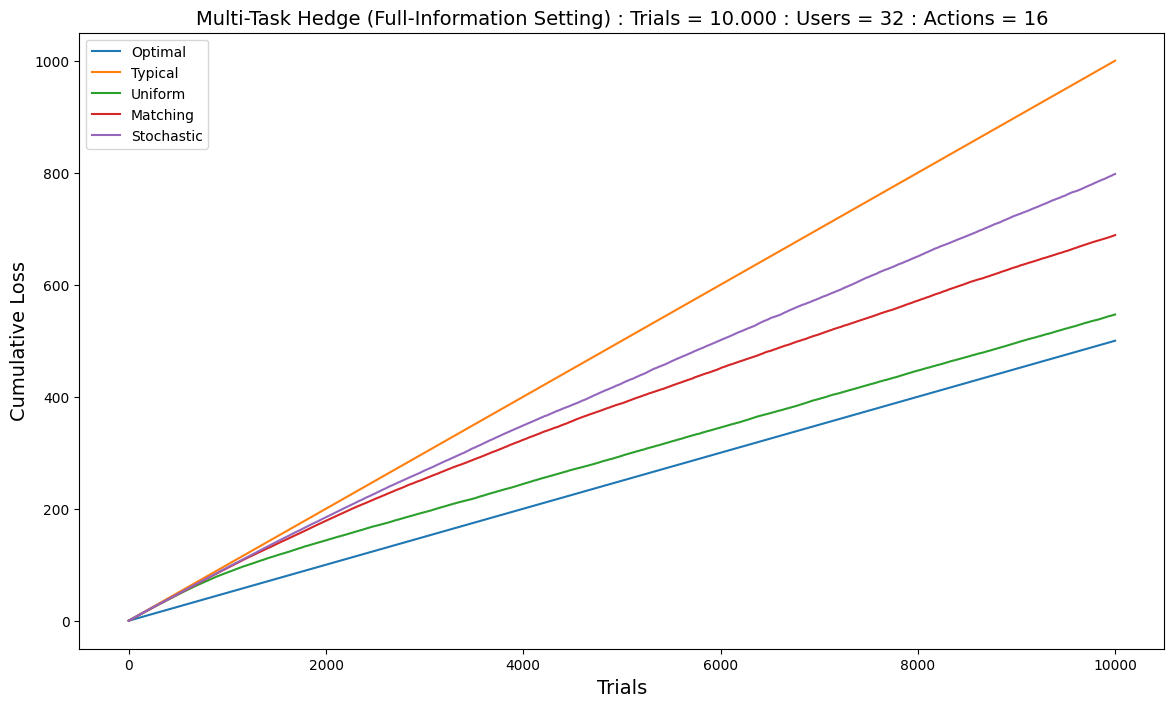

In [61]:
# Multi-Task Hedge
# Full-Information

actions = 16
trials = 10000

start = time.time()
MTH_U = MTH_F(init_uniform)
MTH_M = MTH_F(init_matching)
MTH_S = MTH_F(init_stochastic)
end = time.time()

print(f'Time: {end - start}')

title = 'Multi-Task Hedge (Full-Information Setting) : Trials = 10.000 : Users = 32 : Actions = 16'
plot([MTH_U, MTH_M, MTH_S], ['Uniform', 'Matching', 'Stochastic'], title)

Loss: 637.4395362973481
Loss: 762.4583875899621
Loss: 921.7036590424129
Time: 625.614022731781


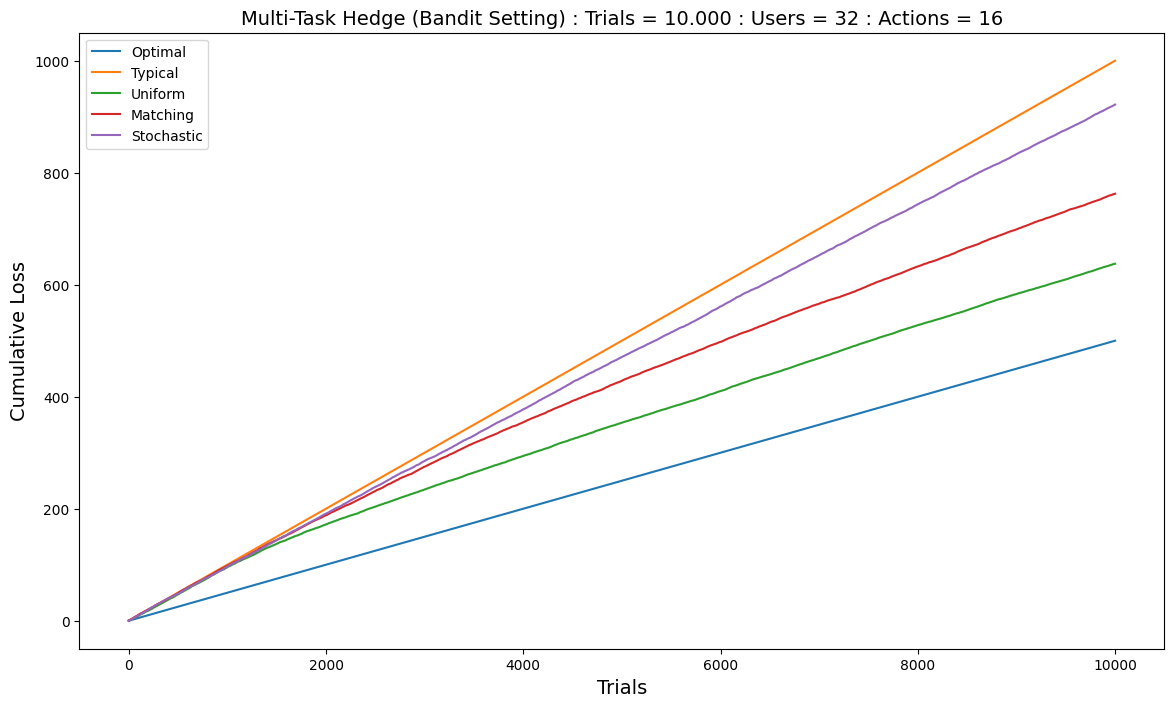

In [62]:
# Multi-Task Hedge
# Bandit Setting

actions = 16
trials = 10000

start = time.time()
MTH_U = MTH_B(init_uniform)
MTH_M = MTH_B(init_matching)
MTH_S = MTH_B(init_stochastic)
end = time.time()

print(f'Time: {end - start}')

title = 'Multi-Task Hedge (Bandit Setting) : Trials = 10.000 : Users = 32 : Actions = 16'
plot([MTH_U, MTH_M, MTH_S], ['Uniform', 'Matching', 'Stochastic'], title)

Loss: 5925.250284675659
Loss: 6454.983176158498
Loss: 6946.024434995877
Time: 139.25625729560852


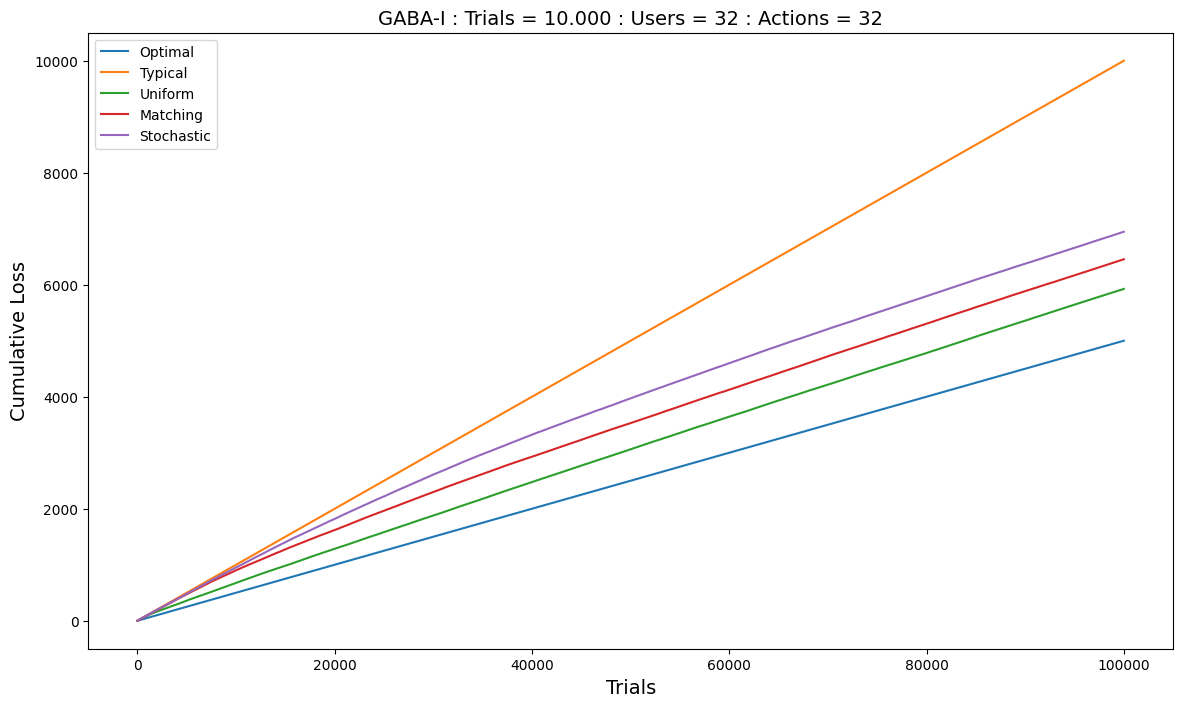

In [63]:
# GABA-I

actions = 32
trials = 100000

start = time.time()
GABA_U = GABA_I(init_uniform)
GABA_M = GABA_I(init_matching)
GABA_S = GABA_I(init_stochastic)
end = time.time()

print(f'Time: {end - start}')

title = 'GABA-I : Trials = 10.000 : Users = 32 : Actions = 32'
plot([GABA_U, GABA_M, GABA_S], ['Uniform', 'Matching', 'Stochastic'], title)